<a href="https://colab.research.google.com/github/brdeleon/flagging_loans_shapley_values/blob/main/flagging_loans_final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flagging Loans - Final Model with Shapley 

This notebook goes over the final model and uses Shapley values to interpret the models predictions. 
The other notebooks in this repository go over EDA, preprocessing, and model selection. 

## Imports
#### Install the necessary libraries:

In [29]:
pip install shap imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import the necessary libraries and modules:

In [31]:
import warnings
warnings.filterwarnings("ignore")

import joblib as jb
from joblib import dump, load

import os
import shap
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


### Importing Data

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Note that the df being imported has already been cleaned. For data cleaning process please see other notebooks in this repository.

In [33]:
df = pd.read_csv('/content/drive/MyDrive/loan_data/df.csv')

## Modeling

### Evaluation Function

In [34]:
# Defining an evaluation classification function for automation and evaluating subsequent models
def evaluate_classification(model, X_train, X_test, y_train, y_test, classes=None, 
                            normalize='true', cmap='Reds', label=''):
    
    """Input a model, training data and validation data to return sklearn metrics
        - Classification Report for training and validation 
        - PR AUC Score for training and validation 
        - Confusion Matrix for training and validation 
        - ROC Curve for training and validation
        - PR Curve for training and validation
        
        Args:
        model: instantiated classifier (ex: LogisticRegression = log_reg)
        X_train: train_test_split & preprocessed
        X_test: train_test_split 
        y_train: train_test_split & preprocessed
        y_test: train_test_split 
        label: optional label for type of classifier 
    """
    # retrieve predictions for train and validation data 
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # retrieve probabilites for train and validation data 
    y_hat_train = model.predict_proba(X_train)
    y_hat_test = model.predict_proba(X_test)
    
    # retrieve probabilities for the positive class
    pos_probs_train = y_hat_train[:, 1]
    pos_probs_test = y_hat_test[:, 1]
    
    # print training classification report 
    header = label + " Classification Report Training "
    dashes = "---" * 20
    print(dashes, header, dashes, sep='\n')
    print(classification_report(y_train, y_pred_train, target_names=classes))
    
    # Display training figures 
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,4))

    # Plot confusion matrix
    ConfusionMatrixDisplay.from_estimator(estimator=model, X=X_train, y=y_train, display_labels=classes, cmap=cmap, ax=axes[0])
    axes[0].set(title='Confusion Matrix - Training')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')    
    
    # Plot ROC curve
    RocCurveDisplay.from_estimator(model, X_train, y_train, name=label, ax=axes[1])
    axes[1].plot([0,1], [0,1], ls=':', label='No Skill')
    axes[1].grid()
    axes[1].set_title('Receiving Operator Characteristic - Training')

    # Plot Precision-Recall curve
    PrecisionRecallDisplay.from_estimator(model, X_train, y_train, ax=axes[2], name=label)
    # y axis is Precision
    axes[2].set_ylabel('Precision')
    # x axis is Recall
    axes[2].set_xlabel('Recall')
    axes[2].set_title('Precision-Recall AUC Training')
    fig.tight_layout()
    plt.show()

    # print validation classification report 
    header_ = label + "Classification Report Test"
    print(dashes, header_, dashes, sep='\n')
    print(classification_report(y_test, y_pred_test, target_names=classes))
    
    # display validation figures 
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
    
    # Plot confusion matrix
    ConfusionMatrixDisplay.from_estimator(estimator=model, X=X_test, y=y_test, display_labels=classes, cmap=cmap, ax=axes[0])
    axes[0].set(title='Confusion Matrix - Test')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')
    
    # Plot ROC curve
    RocCurveDisplay.from_estimator(model, X_test, y_test, name=label, ax=axes[1])
    axes[1].plot([0,1], [0,1], ls=':', label='No Skill')
    axes[1].grid()
    axes[1].set_title('Receiving Operator Characteristic - Test')

    # Plot Precision-Recall curve
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=axes[2], name=label)
    # y axis is Precision
    axes[2].set_ylabel('Precision')
    # x axis is Recall
    axes[2].set_xlabel('Recall')
    axes[2].set_title('Precision-Recall AUC Test')
    plt.legend()
    fig.tight_layout()
    plt.show()

### Data Split

Split data into training and test sets. Training set is used to train the machine learning model, training set is used to evaluate performance of models during training, and the test set is used to evaluate final performance. It is important that the class distribution is preserved across the sets. We specify for data to be split in a stratified fashion, using the class labels. Using stratification helps ensure that the proportion of the target class in each split is close to that of the original data for a fair comparison.

In [35]:
# Defining X and y for data split
X = df.drop('bad_flag', axis=1)
y = df['bad_flag']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Object Type Data

Transform categorical variables into a numerical format that can be more easily interpreted by machine learning algorithms.

In [36]:
# Use ColumnTransformer to apply preprocessing steps to the categorical features
preprocessor = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(sparse=False), ['federal_district_nm']),
],
    remainder="passthrough" # remainder data will pass through without transformation, instead of being dropped
)

In [37]:
# Apply preprocessing steps to the training data
X_train = preprocessor.fit_transform(X_train)

# Apply preprocessing steps to the testing data
X_test = preprocessor.transform(X_test)

In [38]:
# One-hot encode the federal_district_nm column
encoder = preprocessor.named_transformers_['ohe']
column_names = encoder.get_feature_names_out(['federal_district_nm'])
new_columns = list(column_names) + [col for col in X.columns if col not in ['federal_district_nm']]

In [39]:
# Convert arrays into Pandas DataFrame
X_train = pd.DataFrame(X_train, columns= new_columns)
X_test = pd.DataFrame(X_test, columns= new_columns)

### Pipeline Building

To avoid data leakage we will build a model using a pipeline. Using pipeline helps prevent data leakage by creating a clear separation between the preprocessing and modeling steps.


**Next:** We will add sampling techniques to help the model with the imbalanced data. The sampling techniques will require an imblearn pipeline.

### Random Forest imblearn pipeline

Define the pipeline as an imblearn pipeline:

In [40]:
# Define the under and over samplers
undersampler = RandomUnderSampler(sampling_strategy=0.5, 
                         random_state=42)
oversampler = RandomOverSampler(sampling_strategy='minority', 
                        random_state=42)

# Define the random forest classifier
classifier = RandomForestClassifier(max_depth=10, 
                            min_samples_split=10, 
                            n_estimators=300, 
                            max_features='sqrt', 
                            class_weight='balanced_subsample', 
                            random_state=42)

Train the pipeline on the training set:

In [41]:
# Define the pipeline
final_pipeline = imbPipeline(steps=[
    ('undersampler', undersampler), 
    ('oversampler', oversampler), 
    ('classifier', classifier)])

In [42]:
# Fit the pipeline
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('undersampler',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('oversampler',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy='minority')),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=10, min_samples_split=10,
                                        n_estimators=300, random_state=42))])

------------------------------------------------------------
Under and Over Sampled Random Forest Classification Report Training 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      2974
           1       0.38      0.94      0.54       330

    accuracy                           0.84      3304
   macro avg       0.69      0.89      0.72      3304
weighted avg       0.93      0.84      0.87      3304



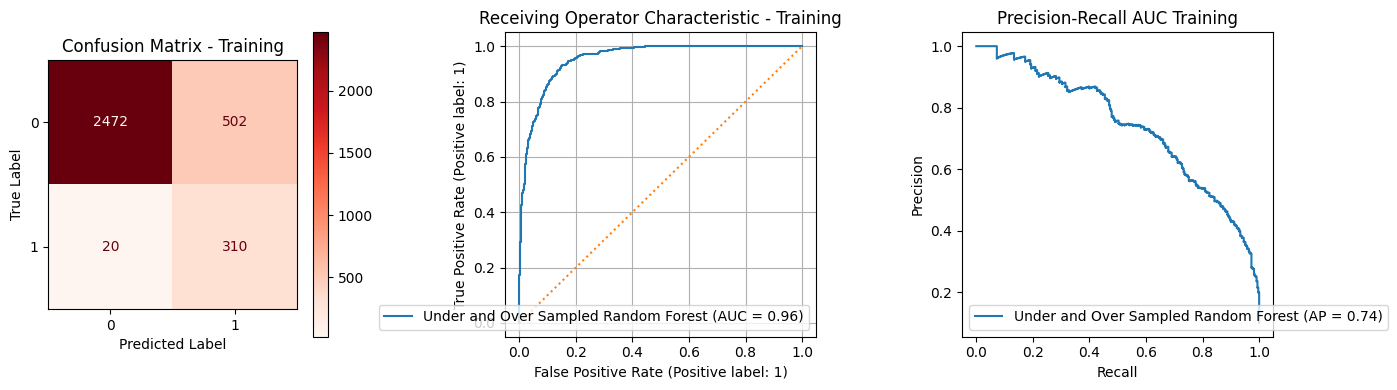

------------------------------------------------------------
Under and Over Sampled Random ForestClassification Report Test
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.80      0.87       745
           1       0.26      0.66      0.38        82

    accuracy                           0.78       827
   macro avg       0.61      0.73      0.62       827
weighted avg       0.89      0.78      0.82       827



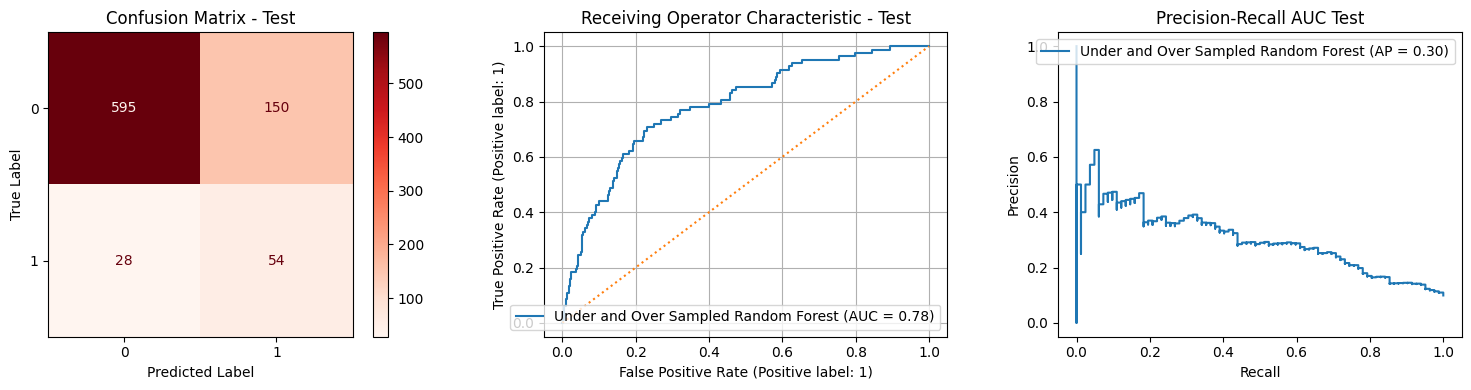

In [43]:
# Classification report using function 
evaluate_classification(final_pipeline,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Under and Over Sampled Random Forest')

## **Shapley Values**
To plot SHAP (SHapley Additive exPlanations) values, we need to first create a TreeExplainer object for the random forest model in the pipeline. Then, we will use the TreeExplainer object to compute the SHAP values for a given set of input data.

## Global Interpretability
### Summary Plot
The shap.summary_plot() function plots the SHAP values for each feature in descending order of importance.

Create a SHAP explainer:

In [44]:
# Extracts the inner classifier from the final_pipeline object
rf = final_pipeline.named_steps['classifier']
# Define the shap explainer for the random forest classifier of the final pipeline
explainer = shap.TreeExplainer(rf)

Generate SHAP values for the testing set:

In [45]:
shap_values = explainer.shap_values(X_test)

Plot the SHAP values:

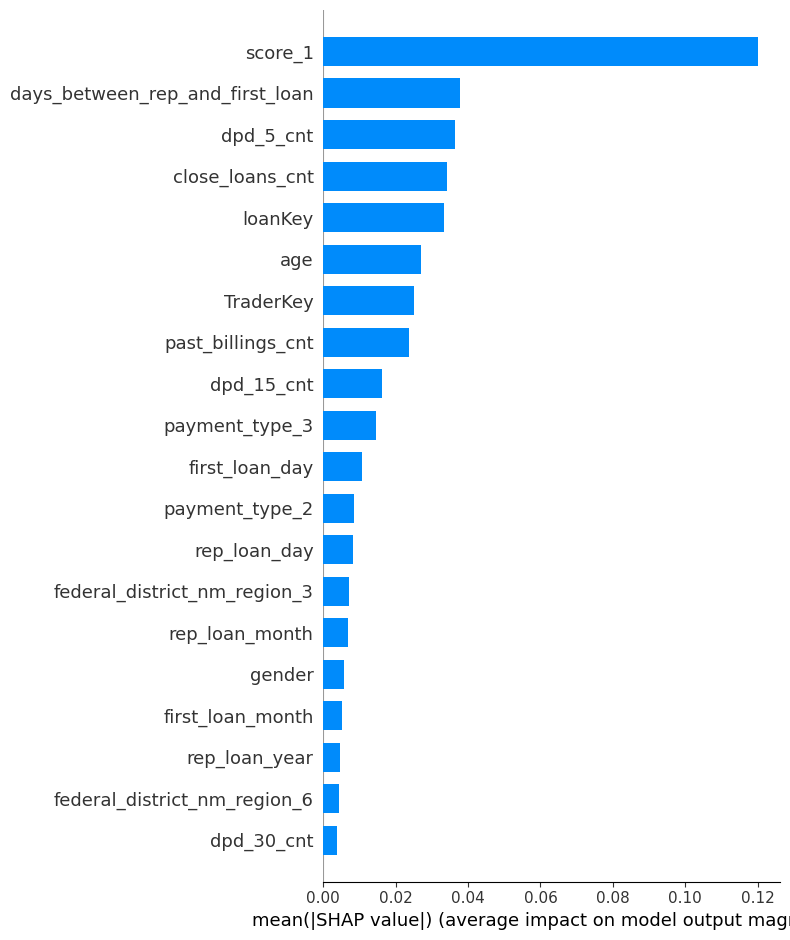

In [46]:
# Specify shap values for the target class, X_test as our feature values, and bar plot type
shap.summary_plot(shap_values[1], X_test, plot_type='bar', show=False)
plt.show()

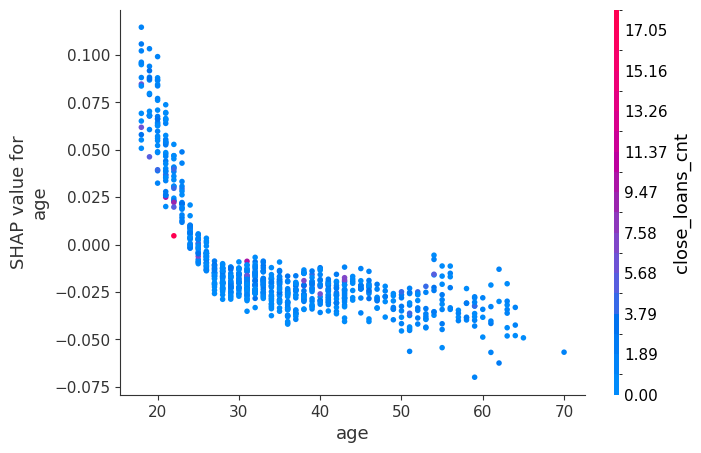

In [48]:
# Plot the SHAP values for the "age" feature
shap.dependence_plot("age", shap_values[1], X_test)

## Local Interpretability
### Force Plot
A force plot shows how each feature is contributing to the prediction for that instance. The length and color of the bars represent the magnitude and direction of the feature's impact on the prediction.

By visually inspecting the force plot for multiple predictions, we can get a sense of whether the model is relying on any potentially discriminatory or biased features to make its predictions.

Create a Shap explainer using the TreeExplainer() function from the shap library, passing in the fitted pipeline.

In [49]:
# Create a Shap explainer using the TreeExplainer() function
explainer = shap.TreeExplainer(final_pipeline.named_steps['classifier'])

Use the shap_values() function from the explainer to generate Shapley values for a subset of the testing data.

In [50]:
# Generate Shapley values for a subset of the testing data
sampled_X_test = X_test.sample(100)
shap_values = explainer.shap_values(sampled_X_test)

Note that the expected_value argument passed to shap.force_plot() is set to 1 because we are interested in the positive class. 

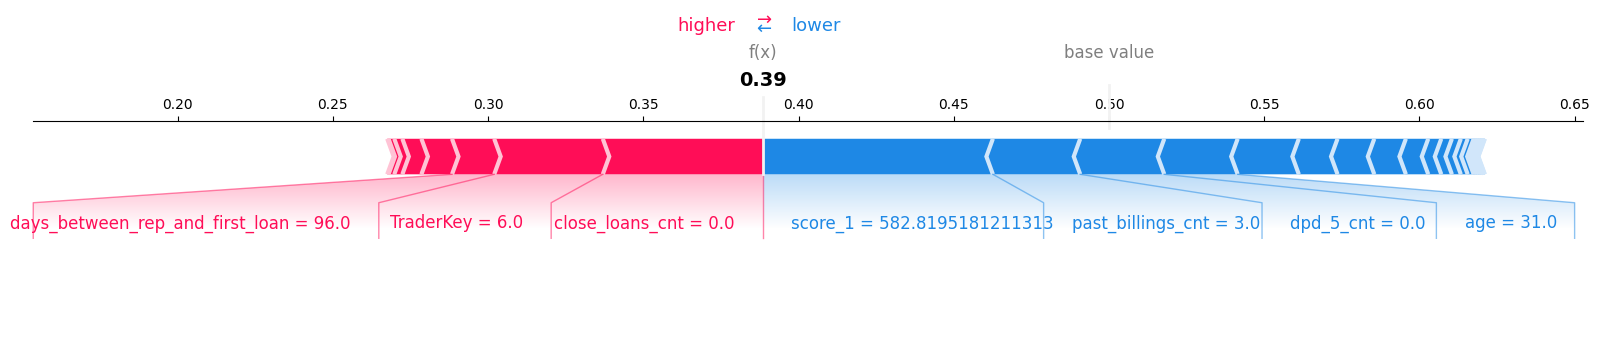

In [51]:
# Visualize the Shapley values for a specific instance of the testing data using force_plot()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], sampled_X_test.iloc[0,:], matplotlib=True, show=False)

# Display the plot
plt.show()

## Waterfall Plot
 We are using the shap.waterfall_plot() function to generate a waterfall plot for the first instance in X_test. We pass the SHAP values for the target class (shap_values[1][0]) and the feature values for the first instance in X_test (X_test.iloc[0,:]) as arguments to the function. We then use plt.title() to set the title of the plot and finally use plt.show() to display the plot.

In [52]:
rf = final_pipeline.named_steps['classifier']
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

In [53]:
# Wrap shap_values in a shap.Explanation object
shap_explanation = shap.Explanation(
    values=shap_values[1][0], 
    base_values=explainer.expected_value[1],
    data=X_test.iloc[0,:]
)

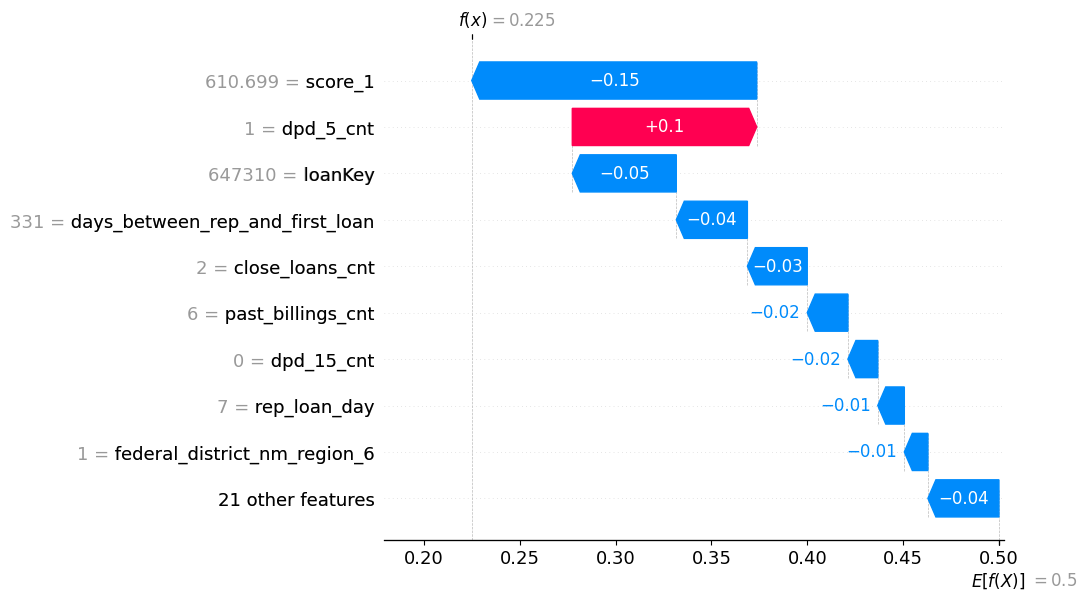

In [54]:
# Generate a waterfall pot using shap_expalnation object
shap.plots.waterfall(shap_explanation, max_display=10)